In [2]:
import pandas as pd
import numpy as np
%pwd

'/Users/IvanTang/quant/IMC_Prosperity3_GraniteFlow/src/analysis/round1'

In [3]:
df1 = pd.read_csv('../../../data/round-1-island-data-bottle/prices_round_1_day_-2.csv', delimiter = ";")
df2 = pd.read_csv('../../../data/round-1-island-data-bottle/prices_round_1_day_-1.csv', delimiter = ";")
df3 = pd.read_csv('../../../data/round-1-island-data-bottle/prices_round_1_day_0.csv', delimiter = ";")

In [4]:
df = pd.concat([df1, df2, df3])

In [5]:
def orderbook_preprocess(df):
    """
    对订单簿数据进行预处理
    1.填充NAN为0
    2.计算best_bid, best_ask, spread, mid_price, vwap, orderbook_imbalance, ask_bid_ratio
    """

    #填充orderbook数据,nan填为0
    columns = ['ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2', 'ask_price_3', 'ask_volume_3', 'bid_price_1', 'bid_volume_1', 'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3']
    for column in columns:
        df[column] = df[column].fillna(0)
    
    #计算best_bid, best_ask, spread, mid_price, vwap
    df['best_bid'] = df[['bid_price_1', 'bid_price_2', 'bid_price_3']].min(axis=1)
    df['best_ask'] = df[['ask_price_1', 'ask_price_2', 'ask_price_3']].max(axis=1)

    #计算best_bid, best_ask

    def get_best_bid_ask_spread(row):
    # 获取有效的买价（去掉NaN） 计算最佳买价
        bid_prices = [row['bid_price_1'], row['bid_price_2'], row['bid_price_3']]
        bid_prices = [price for price in bid_prices if price != 0]
        best_bid = min(bid_prices) if bid_prices else None

        # 获取有效的卖价（去掉NaN） 计算最佳卖价
        ask_prices = [row['ask_price_1'], row['ask_price_2'], row['ask_price_3']]
        ask_prices = [price for price in ask_prices if price != 0]
        best_ask = max(ask_prices) if ask_prices else None
        
        # 计算价差
        spread = best_ask - best_bid
        return best_bid, best_ask, spread

    df[['best_bid', 'best_ask','spread']] = df.apply(get_best_bid_ask_spread, axis=1, result_type='expand')

    #计算mid_price 
    df['mid_price'] = (df['ask_price_1']+ df['bid_price_1']) / 2

    #计算vwap
    df['vwap'] = (df['ask_price_1']*df['ask_volume_1'] + df['ask_price_2']*df['ask_volume_2'] + df['ask_price_3']*df['ask_volume_3'] + df['bid_price_1']*df['bid_volume_1'] + df['bid_price_2']*df['bid_volume_2'] + df['bid_price_3']*df['bid_volume_3']) / (df['ask_volume_1'] + df['ask_volume_2'] + df['ask_volume_3'] + df['bid_volume_1'] + df['bid_volume_2'] + df['bid_volume_3'])
    
    #计算orderbook_imbalance
    def orderbook_imbalance(row):
        """ 计算订单簿不平衡度 """
        buy_orders = [(row['bid_price_1'], row['bid_volume_1']), (row['bid_price_2'], row['bid_volume_2']), (row['bid_price_3'], row['bid_volume_3'])]
        sell_orders = [(row['ask_price_1'], row['ask_volume_1']), (row['ask_price_2'], row['ask_volume_2']), (row['ask_price_3'], row['ask_volume_3'])]
        buy_pressure = sum(amount for price, amount in buy_orders if price != 0)
        sell_pressure = sum(amount for price, amount in sell_orders if price != 0)
        total_pressure = buy_pressure + sell_pressure
        if total_pressure == 0:
            return 0
        return (buy_pressure - sell_pressure) / total_pressure
    
    df['orderbook_imbalance'] = df.apply(orderbook_imbalance, axis=1)

    #计算ask_bid_ratio
    df['ask_volume'] = df['ask_volume_1'] + df['ask_volume_2'] + df['ask_volume_3']
    df['bid_volume'] = df['bid_volume_1'] + df['bid_volume_2'] + df['bid_volume_3']
    df['ask_bid_ratio'] = (df['ask_volume'] - df['bid_volume']) / (df['ask_volume'] + df['bid_volume'])
    

    return df

In [6]:
df = orderbook_preprocess(df)

In [ ]:
def extract_product_df(df, symbol: str):
    df_product = df[df['product'] == symbol]
    #重新设置索引
    df_product.reset_index(drop=True, inplace=True)
    return df_product

In [68]:
df_kelp = extract_product_df(df, 'KELP')
df_resin = extract_product_df(df, 'RAINFOREST_RESIN')
df_ink = extract_product_df(df, 'SQUID_INK')

In [94]:
from scipy.stats import kurtosis
def generate_features(df):
        df = df.copy()
        df['mid_price'] = (df['ask_price_1'] + df['bid_price_1']) / 2
        df['spread'] = df['ask_price_1'] - df['bid_price_1']
        df['vwap'] = (
            df['ask_price_1'] * df['ask_volume_1'] +
            df['ask_price_2'] * df['ask_volume_2'] +
            df['ask_price_3'] * df['ask_volume_3'] +
            df['bid_price_1'] * df['bid_volume_1'] +
            df['bid_price_2'] * df['bid_volume_2'] +
            df['bid_price_3'] * df['bid_volume_3']
        ) / (
            df['ask_volume_1'] + df['ask_volume_2'] + df['ask_volume_3'] +
            df['bid_volume_1'] + df['bid_volume_2'] + df['bid_volume_3']
        )

        df['ask_volume'] = df['ask_volume_1'] + df['ask_volume_2'] + df['ask_volume_3']
        df['bid_volume'] = df['bid_volume_1'] + df['bid_volume_2'] + df['bid_volume_3']
        df['ask_bid_ratio'] = (df['ask_volume'] - df['bid_volume']) / (df['ask_volume'] + df['bid_volume'])
        df['log_return_5'] = np.log(df['mid_price']).diff(-5)
        df['log_return_1'] = np.log(df['mid_price']).diff(-1)
        df['vol_10'] = df['mid_price'].rolling(10).std()
        df['kurt_50'] = df['log_return_5'].rolling(50).apply(lambda x: kurtosis(x, fisher=False), raw=True)
        df['mid_mean_20'] = df['mid_price'].rolling(20).mean()
        df['mid_reversion_gap'] = df['mid_price'] - df['mid_mean_20']
        df['orderbook_imbalance'] = (df['bid_volume'] - df['ask_volume']) / (df['bid_volume'] + df['ask_volume'] )
        df['depth_ratio'] = df['bid_volume_1'] / (df['bid_volume'])
        df['relative_spread'] = df['spread'] / (df['mid_price'])
        df['imbalance_diff'] = df['orderbook_imbalance'].diff(-5)
        df['vol_diff'] = df['vol_10'].diff(-5)
        df['spread_change'] = df['spread'].diff(-5)
        df['return_vol_ratio'] = df['log_return_1'].abs() / (df['vol_10'] )

        #人工构造alpha
        df['alpha1'] = df['log_return_1'] - df['log_return_5']
        df['alpha2'] = df['mid_reversion_gap'] * df['orderbook_imbalance']
        df['alpha3'] = df['spread'] * df['depth_ratio']
        df['alpha4'] = df['vwap'] - df['mid_price']
        df['alpha5'] = df['relative_spread'] * df['return_vol_ratio']
        return df

def get_return(df):
    df = df.copy()
    df['log_return'] = np.log(df['mid_price']).diff(5)
    df['target'] = (df['log_return'] > 0).astype(int)
    return df


In [95]:
def preprocess_price(df):
    df = df.copy()
    df = generate_features(df)
    df= get_return(df)
    df.dropna(inplace=True)
    return df

In [96]:
df_kelp = preprocess_price(df_kelp)
df_resin = preprocess_price(df_resin)
df_ink = preprocess_price(df_ink)

In [97]:
df_kelp.to_csv('../../../data/round1/round1_kelp.csv')
df_resin.to_csv('../../../data/round1/round1_resin.csv')
df_ink.to_csv('../../../data/round1/round1_ink.csv')


In [76]:
#研究因子和log_return5的相关性
def ic_analysis(df):
    feature_cols = [col for col in df.columns if col not in ['day', 'timestamp', 'product', 'profit_and_loss', 'log_return5']]

    df = df.loc[:,['log_return5'] + feature_cols]

    #对所有因子计算ic并且排序
    ic_dict = {}
    selected_cols = []
    for col in feature_cols:
        ic = df.loc[:,['log_return5',col]].corr().iloc[0,1]
        if abs(ic) > 0.5:
            selected_cols.append(col)
        ic_dict[col] = ic
    #排序
    ic_dict = dict(sorted(ic_dict.items(), key=lambda item: abs(item[1]), reverse=True))
    return ic_dict, selected_cols


In [77]:
kelp_dict, kelp_cols = ic_analysis(df_kelp)
resin_dict, resin_cols = ic_analysis(df_resin)
ink_dict, ink_cols = ic_analysis(df_ink)


In [56]:
print(f"kelp_cols: {kelp_cols}, resin_cols: {resin_cols}, ink_cols: {ink_cols}")

kelp_cols: ['mid_reversion_gap', 'alpha4'], resin_cols: ['bid_price_1', 'ask_price_1', 'mid_price', 'mid_reversion_gap', 'alpha4'], ink_cols: ['mid_reversion_gap']


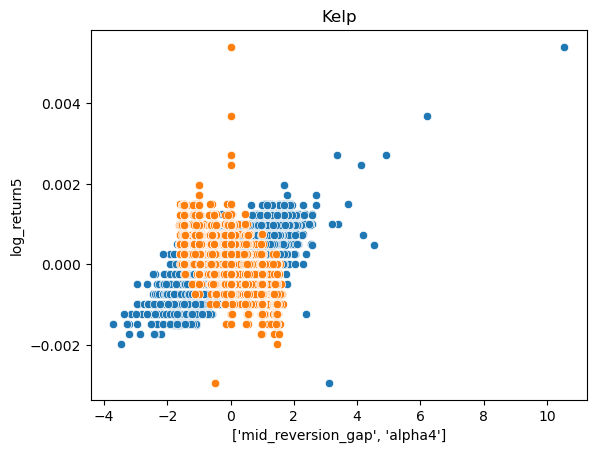

In [64]:
#研究因子和log_return5的关系
import matplotlib.pyplot as plt
import seaborn as sns

for col in kelp_cols:
    sns.scatterplot(x=df_kelp[col], y=df_kelp['log_return5'])
    plt.xlabel(kelp_cols)
    plt.ylabel('log_return5')
    plt.title('Kelp')

plt.show()

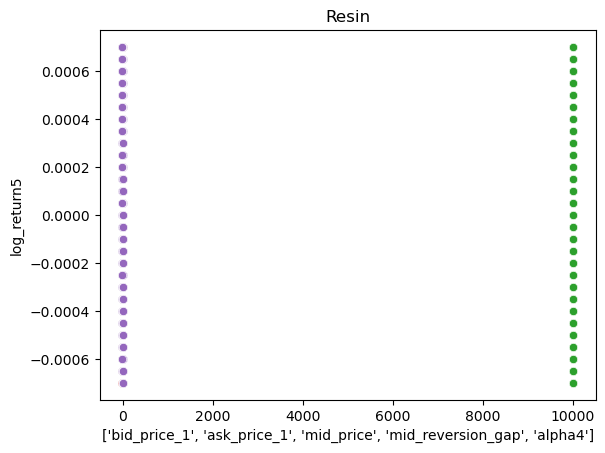

In [65]:
for col in resin_cols:
    sns.scatterplot(x=df_resin[col], y=df_resin['log_return5'])
    plt.xlabel(resin_cols)
    plt.ylabel('log_return5')
    plt.title('Resin')
plt.show()

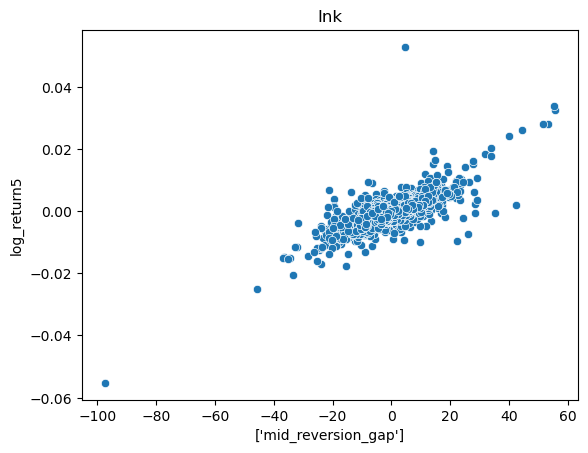

In [66]:
for col in ink_cols:
    sns.scatterplot(x=df_ink[col], y=df_ink['log_return5'])
    plt.xlabel(ink_cols)
    plt.ylabel('log_return5')
    plt.title('Ink')

<Axes: xlabel='mid_price', ylabel='Count'>

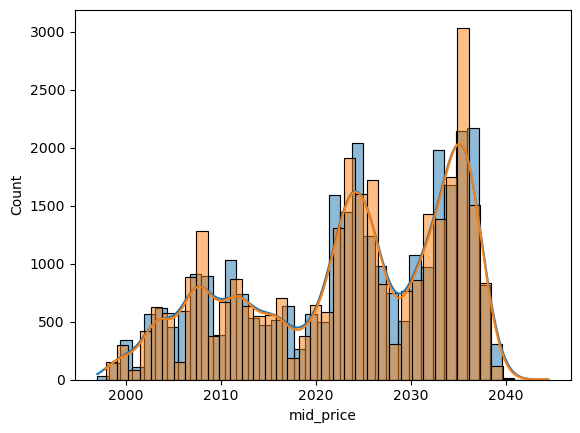

In [148]:
#可视化
import matplotlib.pyplot as plt
import seaborn as sns

#基本因子分布
columns = ['mid_price', 'vwap', 'spread', 'orderbook_imbalance', 'ask_bid_ratio']

sns.histplot(df_kelp['mid_price'], kde=True)
sns.histplot(df_kelp['vwap'], kde = True)


count    30000.000000
mean         0.000060
std          0.061267
min         -0.636364
25%          0.000000
50%          0.000000
75%          0.015385
max          0.621622
Name: orderbook_imbalance, dtype: float64
Non zero ratio of orderbook imbalacne: 0.4992


<Axes: xlabel='orderbook_imbalance', ylabel='Count'>

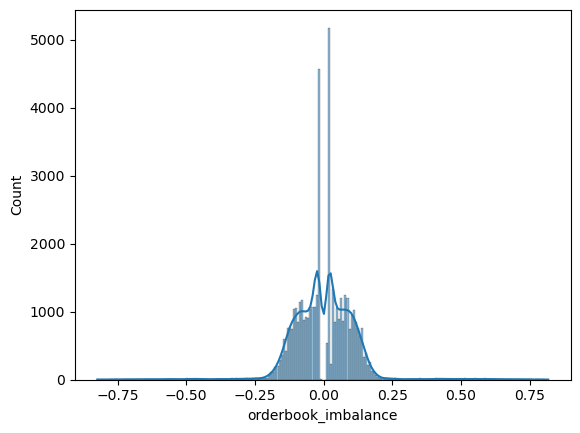

In [ ]:
print(df_kelp['orderbook_imbalance'].describe())

#计算0的个数和非0个数
zero_count = df_kelp['orderbook_imbalance'].value_counts().get(0, 0)
#计算非0的个数
non_zero_ratio = zero_count / len(df_kelp)
print(f'Non zero ratio of orderbook imbalance: {non_zero_ratio}')

df_kelp_filterd = df[df['orderbook_imbalance']!= 0]
sns.histplot(df_kelp_filterd['orderbook_imbalance'], kde = True)


count    30000.000000
mean        -0.000060
std          0.061267
min         -0.621622
25%         -0.015385
50%          0.000000
75%          0.000000
max          0.636364
Name: ask_bid_ratio, dtype: float64
Non zero ratio of ask bid ratio: 0.4992


<Axes: xlabel='ask_bid_ratio', ylabel='Count'>

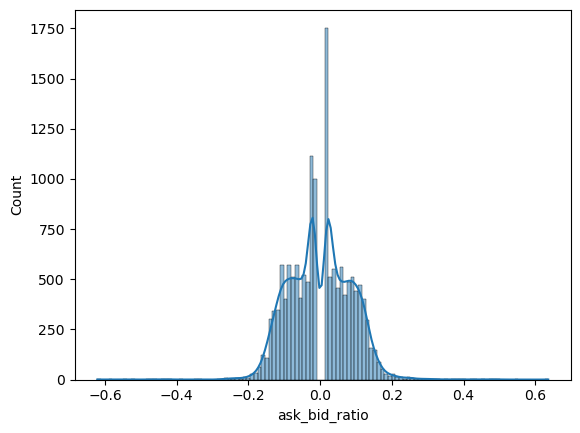

In [151]:
print(df_kelp['ask_bid_ratio'].describe())
#计算0的个数和非0个数
zero_count = df_kelp['ask_bid_ratio'].value_counts().get(0, 0)
#计算非0的个数
non_zero_ratio = zero_count / len(df_kelp)
print(f'Non zero ratio of ask bid ratio: {non_zero_ratio}')

df_kelp_filterd = df_kelp[df_kelp['ask_bid_ratio'] != 0]
sns.histplot(df_kelp_filterd['ask_bid_ratio'], kde = True)

In [152]:
import math
def fractional_derivative(ts, alpha, n_terms=10):
    """
    计算时间序列 ts 的分数阶导数
    参数:
        ts: 时间序列
        alpha: 阶数
        n_terms: 历史项的数量，控制内存长短

    返回:
        分数阶导数序列（长度与 ts 相同，前面一些值为 nan）
    """

    def binomial_coeff(a, k):
        return math.gamma(a + 1) / (math.gamma(k + 1) * math.gamma(a - k + 1))

    ts = np.asarray(ts)
    result = np.full_like(ts, np.nan, dtype=np.float64)

    for t in range(n_terms, len(ts)):
        val = 0.0
        for k in range(n_terms):
            coeff = (-1) ** k * binomial_coeff(alpha, k)
            val += coeff * ts[t - k]
        result[t] = val
    return result

def rolling_window(ts, window_length: int):
    ts_diff = ts.diff(window_length)
    ts_vol = ts.rolling(window_length).std()
    ts_mean = ts.rolling(window_length).mean()
    ts_zscore = (ts - ts_mean) / ts_vol
    return ts_diff, ts_vol, ts_mean, ts_zscore


In [161]:
from scipy.stats import kurtosis

def get_return(df):
    df = df.copy()
    df['mid_price_diff_5'] = df['mid_price'] - df['mid_price'].shift(5)
    df['log_return_5'] = np.log(df['mid_price']).diff(5)
    df.dropna(inplace=True)
    k = kurtosis(df['log_return_5'])
    print("Kurtosis of log_return_5: ", k)
    return df

In [162]:
df_kelp = get_return(df_kelp)

Kurtosis of log_return_5:  1.8750666843239419


In [163]:
print(df_kelp.head())
print(df_kelp['log_return_5'].describe())

    day  timestamp product  bid_price_1  bid_volume_1  bid_price_2  \
45   -2       1500    KELP         1999            27          0.0   
49   -2       1600    KELP         1999            24          0.0   
52   -2       1700    KELP         1999            28          0.0   
54   -2       1800    KELP         1999            24          0.0   
57   -2       1900    KELP         2001             1       1999.0   

    bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  ...  best_bid  \
45           0.0          0.0           0.0         2002  ...    1999.0   
49           0.0          0.0           0.0         2002  ...    1999.0   
52           0.0          0.0           0.0         2001  ...    1999.0   
54           0.0          0.0           0.0         2001  ...    1999.0   
57          26.0          0.0           0.0         2002  ...    1999.0   

    best_ask  spread         vwap  orderbook_imbalance  ask_volume  \
45    2002.0     3.0  2000.500000             0.000000    

<Axes: xlabel='mid_price_diff', ylabel='Count'>

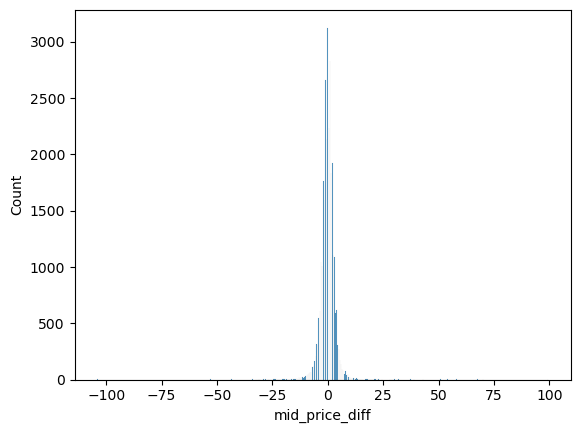

In [ ]:
sns.histplot(df_ink['mid_price_diff'])

In [171]:
def IC_IR(df, factor_column: str, return_column: str, risk_free_rate: float):
    """
    Calculate the Information Coefficient (IC) and Implied Risk-Free Rate (IRR) of a factor using the CAPM model.
    :param df: DataFrame with columns for the factor, return, and market return.
    :param factor_column: Name of the column containing the factor values.
    :param return_column: Name of the column containing the return values.
    :param risk_free_rate: Risk-free rate used in the CAPM model.
    :return: Tuple of the IC and IRR values.
    """
    # Calculate the market return
    market_return = df[return_column].mean()
    # Calculate the CAPM beta
    beta = (df[return_column] - risk_free_rate - df[factor_column] * market_return) / (df[factor_column] ** 2)

    # Calculate the CAPM alpha
    alpha = market_return - risk_free_rate - beta * df[factor_column]

    # Calculate the Information Coefficient (IC)
    ic = (beta ** 2) / (1 - beta ** 2)

    # Calculate the Implied Risk-Free Rate (IRR)
    irr = (1 + alpha) / (1 + beta)
    return ic, irr


In [176]:
df_ink['kurt_50'] = df_ink['log_return_5'].rolling(50).apply(kurtosis)
df_ink.dropna(inplace=True)
ic, irr = IC_IR(df_ink, 'log_return_5', 'kurt_50', 0)
#print(ic, irr)


In [ ]:
print(ic.describe())
sns.histplot(ic, kde=False)

count    26778.000000
mean        -1.000000
std          0.000036
min         -1.005501
25%         -1.000000
50%         -1.000000
75%         -1.000000
max         -1.000000
dtype: float64


In [ ]:
def calculate_factors(df):
    """
    计算因子：
    订单簿因子：orderbook_imbalance, ask_bid_ratio（已实现）
    基本因子：对数收益率（5）， 波动率（10）
    肥尾因子：kurt(50)
    衍生因子：上述的1阶差分和1/2阶差分
    """
    df['log_return5'] = np.log(df['mid_price']).diff(5)
    df['vol10'] = df['mid_price'].rolling(10).std()
    df['kurt50'] = df['log_return_5'].rolling(10).kurt()
    df['orderbook_imbalance_5_1/2'] = fractional_derivative(df['orderbook_imbalance'], 1/2, 5)
    df['orderbook_imbalance_5_1'] = fractional_derivative(df['orderbook_imbalance'], 1, 5)
    df['ask_bid_ratio_5_1/2'] = fractional_derivative(df['ask_bid_ratio'], 1/2, 5)
    df['ask_bid_ratio_5_1'] = fractional_derivative(df['ask_bid_ratio'], 1, 5)
    df['vol10_5_1/2'] = fractional_derivative(df['vol10'], 0.5, 5)
    df['vol10_5_1'] = fractional_derivative(df['vol10'], 1, 5)
    df['kurt50_5_1/2'] = fractional_derivative(df['kurt50'], 0.5, 5)
    df['kurt_50_1'] = fractional_derivative(df['kurt50'], 1, 5)
    return df

In [78]:
df_ink0 = df_ink[df_ink['day'] == -2]

In [79]:
print(df_ink0)

      day  timestamp    product  bid_price_1  bid_volume_1  bid_price_2  \
0      -2          0  SQUID_INK         1998            26          0.0   
1      -2        100  SQUID_INK         1999             5       1998.0   
2      -2        200  SQUID_INK         1997            31          0.0   
3      -2        300  SQUID_INK         1997            27          0.0   
4      -2        400  SQUID_INK         1996            20          0.0   
...   ...        ...        ...          ...           ...          ...   
9995   -2     999500  SQUID_INK         2000            26          0.0   
9996   -2     999600  SQUID_INK         2001            30          0.0   
9997   -2     999700  SQUID_INK         2001            22          0.0   
9998   -2     999800  SQUID_INK         2002            26          0.0   
9999   -2     999900  SQUID_INK         2003             4       2002.0   

      bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  ...  \
0              0.0          0.0 